In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from typing import Callable, List, Optional, Tuple
import sys, os
import pandas as pd

from data_loader import load_grid_search_data, get_recon_landscape, load_optimization_path, get_interpolation_path_filename

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

def _vis_landscapes(
        fig,
        axs: plt.Axes,
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(params_paths)

    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'], indexing="ij")

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_xlabel(r'$\beta$')
        if idx == 0:
            axs[idx].set_ylabel(r'$\gamma$')
        # else:
        axs[idx].set_yticks([])
        axs[idx].set_xticks([])
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[0])
                ys.append(param[1])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="opt. path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial pt")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged pt")

            # axs[idx].legend(loc='upper center')

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))], pad=0.05)
    # plt.legend()
    # fig.tight_layout()

# Fig. 13, An example of choosing the optimizer based on the interpolated reconstructed optimization


read grid search data from figs/grid_search/qaoa/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-RichardsonFactory.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-depolar-0.001-0.02-p=1/recon-cs_seed=16-sf=0.050-maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-RichardsonFactory.npz
save to  paper_figs/compare_ADAM_and_COBYLA.pdf


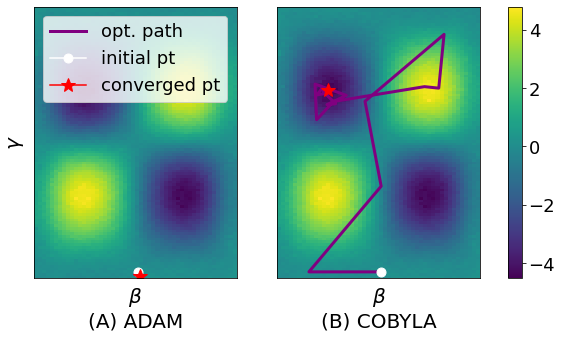

In [6]:
# n16
def vis_choose_optimizer(n, p, noise, seed, miti_method):
    problem = 'maxcut'
    method = 'sv'
    cs_seed = n
    maxiter = 1000
    ansatz = 'qaoa'

    sf = 0.05
    if p == 1:
        bs = 50
        gs = 100
    elif p == 2:
        bs = 12
        gs = 15
    else:
        raise NotImplementedError()

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n, p=p, ansatz=ansatz, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    recon_dir = f"figs/grid_search_recon/{problem}/{method}-{noise}-p={p}"
    plot_range = data['plot_range']

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape(ansatz, p, origin, sf, False, recon_path, cs_seed)

    init_pt = [0.02, -1.51]

    # intp_path_path, _, _ = get_interpolation_path_filename(n, p, problem, method, noise, optimizer, maxiter, init_pt, seed, None)
    # print("intp path:", intp_path_path)
    # intp_path = np.load(intp_path_path, allow_pickle=True)['intp_path']

    adam_data = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-ADAM-maxiter=1000-[0.02, -1.51].npz"
        , allow_pickle=True
    )
    
    cobyla_data = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-COBYLA-maxiter=1000-[0.02, -1.51].npz"
        , allow_pickle=True
    )
    
    # circ_path = np.load(
    #     "figs/optimization/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz"
    #     , allow_pickle=True
    # )['optimizer_path']
    # circ_path = load_optimization_path(n, p, problem, method, noise, optimizer, None, maxiter, init_pt, seed, None)

    params = {'legend.fontsize': 18,
            'figure.figsize': (10, 5),
            'axes.labelsize': 20, #'x-large',
            'axes.titlesize': 20, #'x-large',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'pdf.fonttype': 42,
            'ps.fonttype': 42,}
    plt.rcParams.update(params)
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    save_path = "paper_figs/compare_ADAM_and_COBYLA.pdf"
    labels=["(A) ADAM", "(B) COBYLA"]
    _vis_landscapes(
        fig,
        axs,
        landscapes=[recon, recon],
        labels=labels,
        full_range=plot_range,
        true_optima=None,
        title="Choose optimize on reconstructed mitigated landscape",
        save_path=save_path,
        params_paths=[adam_data['intp_path'], cobyla_data['intp_path']],
        converged_soln_markers=["*", "*"]
    )

    for idx in [0,1]:
        # axs[idx].legend(loc='lower center')
        axs[idx].set_title(labels[idx], y=-0.2)
    axs[0].legend(loc='upper center')
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')

vis_choose_optimizer(16, 1, "depolar-0.001-0.02", 0, "zne-RichardsonFactory")

# Fig. 11, optimize on the recon landscape by interpolation and circuit simulation


read grid search data from figs/grid_search/qaoa/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-50-100.npz

recon landscape read from figs/grid_search_recon/qaoa/maxcut/sv-ideal-p=1/recon-cs_seed=16-sf=0.050-maxcut-sv-ideal-n=16-p=1-seed=0-50-100.npz
intp path: figs/opt_on_recon_landscape/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz
opt data load from figs/optimization/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz
save to  paper_figs/compare_intp_and_circ.pdf


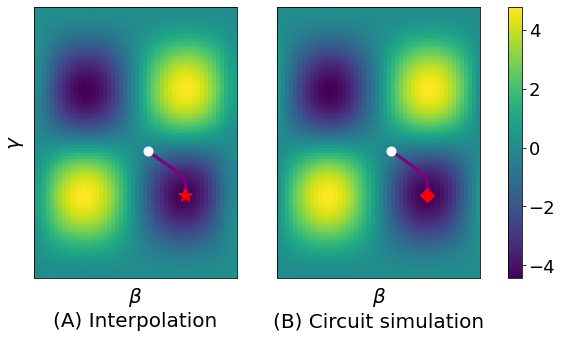

In [7]:
def vis_comp_intp_n16(n: int, p: int, seed: int, noise: str, optimizer: str, maxiter: int, miti_method: str):
    problem = 'maxcut'
    method = 'sv'
    cs_seed = n
    ansatz = 'qaoa'

    sf = 0.05
    if p == 1:
        bs = 50
        gs = 100
    elif p == 2:
        bs = 12
        gs = 15
    else:
        raise NotImplementedError()

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n, p=p, ansatz=ansatz, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    recon_dir = f"figs/grid_search_recon/{ansatz}/{problem}/{method}-{noise}-p={p}"
    plot_range = data['plot_range']

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape(ansatz, p, origin, sf, False, recon_path, cs_seed)

    init_pt = [0.1, -0.1]

    intp_path_path, _, _ = get_interpolation_path_filename(n, p, problem, method, noise, optimizer, maxiter, init_pt, seed, None)
    print("intp path:", intp_path_path)
    intp_path = np.load(intp_path_path, allow_pickle=True)['intp_path']

    # circ_path = np.load(
    #     "figs/optimization/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz"
    #     , allow_pickle=True
    # )['optimizer_path']
    circ_path = load_optimization_path(n, p, problem, method, noise, optimizer, None, maxiter, init_pt, seed, None)
    

    params = {'legend.fontsize': 18,
            'figure.figsize': (10, 5),
            'axes.labelsize': 20, #'x-large',
            'axes.titlesize': 20, #'x-large',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'pdf.fonttype': 42,
            'ps.fonttype': 42,}
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    save_path = "paper_figs/compare_intp_and_circ.pdf"
    labels=["(A) Interpolation", "(B) Circuit simulation"]
    _vis_landscapes(
        fig,
        axs,
        landscapes=[recon, origin],
        labels=labels,
        full_range=plot_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path=save_path,
        params_paths=[intp_path, circ_path],
        converged_soln_markers=["*", "D"]
    )

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.2)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')
vis_comp_intp_n16(16, 1, 0, "ideal", "ADAM", 10000, None)

# Fig. 2, Vis loss and path.


read grid search data from figs/grid_search/qaoa/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-50-100.npz

recon landscape read from figs/grid_search_recon/qaoa/maxcut/sv-ideal-p=1/recon-cs_seed=16-sf=0.050-maxcut-sv-ideal-n=16-p=1-seed=0-50-100.npz
intp path: figs/opt_on_recon_landscape/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz
dict_keys(['opt_name', 'initial_point', 'intp_path', 'circ_path', 'circ_vals'])
save to  paper_figs/cost_vals_and_opt_path.pdf


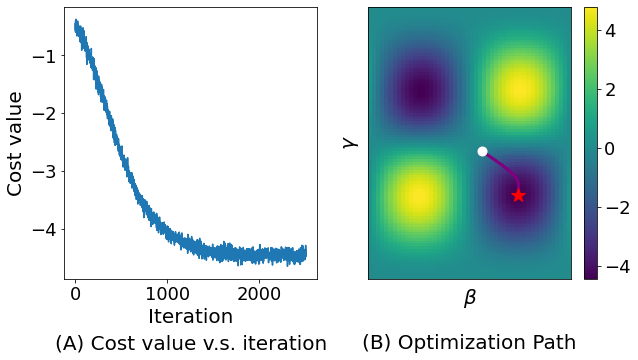

In [8]:
def vis_loss_and_path(n: int, p: int, seed: int, noise: str, optimizer: str, maxiter: int, miti_method: str):
    problem = 'maxcut'
    method = 'sv'
    cs_seed = n
    ansatz = 'qaoa'
    sf = 0.05
    if p == 1:
        bs = 50
        gs = 100
    elif p == 2:
        bs = 12
        gs = 15
    else:
        raise NotImplementedError()

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n, p=p, ansatz=ansatz, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    recon_dir = f"figs/grid_search_recon/{ansatz}/{problem}/{method}-{noise}-p={p}"
    plot_range = data['plot_range']

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape(ansatz, p, origin, sf, False, recon_path, cs_seed)

    init_pt = [0.1, -0.1]

    intp_path_path, _, _ = get_interpolation_path_filename(n, p, problem, method, noise, optimizer, maxiter, init_pt, seed, None)
    print("intp path:", intp_path_path)
    intp_path = np.load(intp_path_path, allow_pickle=True)['intp_path']

    opt_data = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1]-get_vals.npz"
        # "figs/optimization/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz"
        , allow_pickle=True
    )

    print(dict(opt_data).keys())

    circ_path = opt_data['circ_path']
    circ_vals = opt_data['circ_vals']
    # circ_path = load_optimization_path(n, p, problem, method, noise, optimizer, None, maxiter, init_pt, seed, None)

    params = {'legend.fontsize': 18,
            'figure.figsize': (10, 5),
            'axes.labelsize': 20, #'x-large',
            'axes.titlesize': 20, #'x-large',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'pdf.fonttype': 42,
            'ps.fonttype': 42,
         }
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    save_path = "paper_figs/cost_vals_and_opt_path.pdf"
    labels=["(A) Cost value v.s. iteration", "(B) Optimization Path"]
    _vis_landscapes(
        fig,
        axs[1:],
        landscapes=[origin],
        labels=None,
        full_range=plot_range,
        true_optima=None,
        title=None,
        save_path=save_path,
        params_paths=[circ_path],
        converged_soln_markers=["*"]
    )

    axs[0].plot(range(len(circ_vals)), circ_vals)
    axs[0].set_ylabel("Cost value")
    axs[0].set_xlabel("Iteration")

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.28)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')
vis_loss_and_path(16, 1, 0, "ideal", "ADAM", 10000, None)

init pt of intp: [-0.37445878 -0.63305874]
init pt of second: [ 0.38951176 -0.616413  ]

read grid search data from figs/grid_search/qaoa/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=2-50-100.npz

recon landscape read from figs/grid_search_recon/qaoa/maxcut/sv-depolar-0.003-0.007-p=1/recon-cs_seed=16-sf=0.050-maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=2-50-100.npz
circ   path len: 2962
second path len: 451
save to  paper_figs/second_optimize.pdf


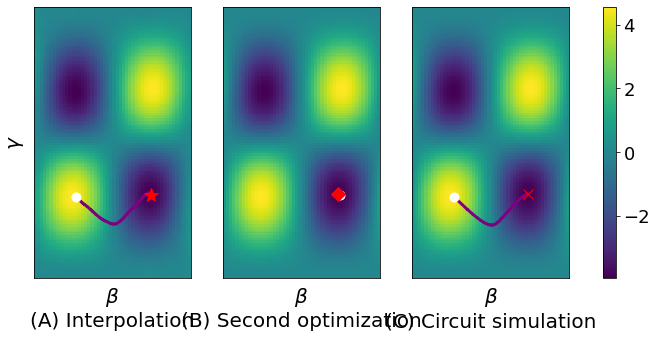

2962 3070
save to  paper_figs/second_optimize.pdf


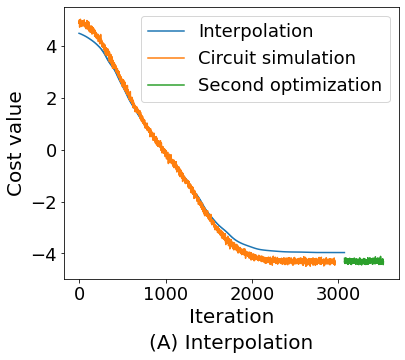

In [9]:
def vis_second_optimize(n: int, p: int, seed: int, noise: str, optimizer: str, maxiter: int, miti_method: str):
    second_opt_data = np.load(
        f"figs/second_optimize/opt_on_recon-n={n}-noise={noise}-seeds=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15-opt={optimizer}-maxiter=10000.npz"
        , allow_pickle=True
    )
    intp_paths = second_opt_data['intp_paths']
    init_pts = second_opt_data['initial_points']

    idx = seed
    intp_path = intp_paths[idx]
    init_pt = init_pts[idx]
    print("init pt of intp:", init_pt)

    second_init_pt = intp_path[-1]

    print("init pt of second:", second_init_pt)
    
    problem = 'maxcut'
    method = 'sv'
    cs_seed = n

    sf = 0.05
    if p == 1:
        bs = 50
        gs = 100
    elif p == 2:
        bs = 12
        gs = 15
    else:
        raise NotImplementedError()
    ansatz = 'qaoa'

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n, p=p, ansatz=ansatz, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    recon_dir = f"figs/grid_search_recon/{ansatz}/{problem}/{method}-{noise}-p={p}"
    plot_range = data['plot_range']

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape(ansatz, p, origin, sf, False, recon_path, cs_seed)

    # init_pt = 

    # intp_path_path, _, _ = get_interpolation_path_filename(n, p, problem, method, noise, optimizer, maxiter, init_pt, seed, None)
    # print("intp path:", intp_path_path)
    # intp_path = np.load(intp_path_path, allow_pickle=True)['intp_path']
    intp_vals = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=2-ADAM-maxiter=10000-[-0.37445878, -0.63305874].npz"
        # "figs/opt_on_recon_landscape/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=2-ADAM-maxiter=10000-[-0.3744587838736487, -0.6330587434834695].npz"
        , allow_pickle=True
    )['intp_vals']
    
    circ_path = np.load(
        "figs/optimization/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=2-ADAM-maxiter=10000-None.npz"
        # "figs/optimization/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=1-ADAM-maxiter=10000-None.npz"
        , allow_pickle=True
    )['optimizer_path']
    circ_vals = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=2-ADAM-maxiter=10000-None.npz"
        , allow_pickle=True
    )['circ_vals']

    second_path = np.load(
        "figs/optimization/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=2-ADAM-maxiter=10000-[0.38977961, -0.61653461].npz"
        # "figs/optimization/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=1-ADAM-maxiter=10000-[-0.393635, 0.639378].npz"
        , allow_pickle=True
    )['optimizer_path']
    second_vals = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-depolar-0.003-0.007-p=1/maxcut-sv-depolar-0.003-0.007-n=16-p=1-seed=2-ADAM-maxiter=10000-[0.38977961, -0.61653461].npz"
        , allow_pickle=True
    )['circ_vals']
    
    # circ_path   = load_optimization_path(n, p, problem, method, noise, optimizer, None, maxiter, None, seed, None)
    # second_path = load_optimization_path(n, p, problem, method, noise, optimizer, None, maxiter, second_init_pt, seed, None)
    
    print("circ   path len:", len(circ_path))
    print("second path len:", len(second_path))
    

    params = {'legend.fontsize': 18,
            'figure.figsize': (12, 5),
            'axes.labelsize': 20, #'x-large',
            'axes.titlesize': 20, #'x-large',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'pdf.fonttype': 42,
            'ps.fonttype': 42,}
    plt.rcParams.update(params)

    complete_path = np.concatenate([intp_path, second_path])

    fig, axs = plt.subplots(nrows=1, ncols=3)
    save_path = "paper_figs/second_optimize.pdf"
    labels=["(A) Interpolation", "(B) Second optimization", "(C) Circuit simulation"]
    _vis_landscapes(
        fig,
        axs,
        landscapes=[recon, origin, origin],
        labels=labels,
        full_range=plot_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path=save_path,
        params_paths=[intp_path, second_path, circ_path],
        converged_soln_markers=["*", "D", "x"]
    )

    for idx in [0,1,2]:
        axs[idx].set_title(labels[idx], y=-0.2)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')

    params = {'legend.fontsize': 18,
            'figure.figsize': (6, 5),
            'axes.labelsize': 20, #'x-large',
            'axes.titlesize': 20, #'x-large',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18}
    plt.rcParams.update(params)
    # circ_vals = second_vals.copy()
    fig, axs = plt.subplots(nrows=1, ncols=1)
    axs = [axs]

    # max_len = 1500
    print(len(circ_vals), len(intp_vals))
    axs[0].plot(range(len(intp_vals)), intp_vals, label="Interpolation")
    axs[0].plot(range(len(circ_vals)), circ_vals, label="Circuit simulation")
    axs[0].plot(len(intp_vals) + np.array(range(len(second_vals))), second_vals, label="Second optimization")
    
    axs[0].legend()
    axs[0].set_ylabel("Cost value")
    axs[0].set_xlabel("Iteration")

    for idx in [0]:
        axs[idx].set_title(labels[idx], y=-0.28)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')

vis_second_optimize(16, 1, 2, "depolar-0.003-0.007", "ADAM", 10000, None)
# vis_second_optimize(16, 1, 0, "ideal", "COBYLA", 1000, None)

# vis

In [10]:
def vis_query_data():
    query_data = np.load(
        "figs/reduce_QPU_queries/opt=['ADAM', 'COBYLA']-init=['random', 'OSCAR']-noise=['ideal', 'noisy'].npz"
        , allow_pickle=True)

    optimizer_pool = query_data['optimizer_pool']
    init_types = query_data['init_types']
    noise_types = query_data['noise_types']
    data = query_data['data']
    OSCAR_additional_queries = query_data['OSCAR_additional_queries']

    print(optimizer_pool)
    print(init_types)
    print(noise_types)
    print(data.shape)
    print(OSCAR_additional_queries)

    # take average over seeds
    data = data.mean(axis=-1)
    print(data.shape)

    # transpose to (optimizer, noise_type, init_type)
    data = data.transpose(0, 2, 1).reshape(-1, len(init_types))
    print(data.shape)

    # add OSCAR_additional_queries to OSCAR cases
    data_add_recon = data[:, 1] + OSCAR_additional_queries
    print(data_add_recon.shape)
    data_add_recon = data_add_recon.reshape(-1, 1)

    table = np.concatenate((data, data_add_recon), axis=1)
    print(table.shape)
    print(table)

    index = list(itertools.product(optimizer_pool, noise_types))
    index = list(map(lambda x: f"{x[0]}, {x[1]}", index))
    # columns = list(itertools.product(init_types, ["", " + recon"]))
    # columns = list(map(lambda x: f"{x[0]}, # opt.{x[1]}", columns))
    columns = ["random, # opt.", "OSCAR, # opt.", "OSCAR, # opt. + recon."]
    print(index)
    print(columns)
    table = np.round(table, 3)
    # pd.set_option('display.float_format', lambda x: '%.3f' % x)
    df = pd.DataFrame(table, index=index, columns=columns)
    print(df)
    df.to_csv('table_data_in_paper/reduce_QPU_queries.csv', index=False)
vis_query_data()

['ADAM' 'COBYLA']
['random' 'OSCAR']
['ideal' 'noisy']
(2, 2, 2, 13)
250
(2, 2, 2)
(4, 2)
(4,)
(4, 3)
[[3126.53846154  369.53846154  619.53846154]
 [3122.84615385  661.46153846  911.46153846]
 [  38.46153846   32.30769231  282.30769231]
 [  39.61538462   32.46153846  282.46153846]]
['ADAM, ideal', 'ADAM, noisy', 'COBYLA, ideal', 'COBYLA, noisy']
['random, # opt.', 'OSCAR, # opt.', 'OSCAR, # opt. + recon.']
               random, # opt.  OSCAR, # opt.  OSCAR, # opt. + recon.
ADAM, ideal          3126.538        369.538                 619.538
ADAM, noisy          3122.846        661.462                 911.462
COBYLA, ideal          38.462         32.308                 282.308
COBYLA, noisy          39.615         32.462                 282.462
